In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator

creator.create("obj", base.Fitness, weights=(-1.0,-1.0))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.05, 'max': 0.07},
  'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../../moltres/python/moltres_xs.py',
     'fhr_assem_gc.inp']],
   'inputs': ['total_pf',
    'sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['total_pf', 'keff']},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 64 -N 64 -d 1 -j 1 moltres-op

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=22)
    ax.set_ylabel(obj_name, fontsize=22)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

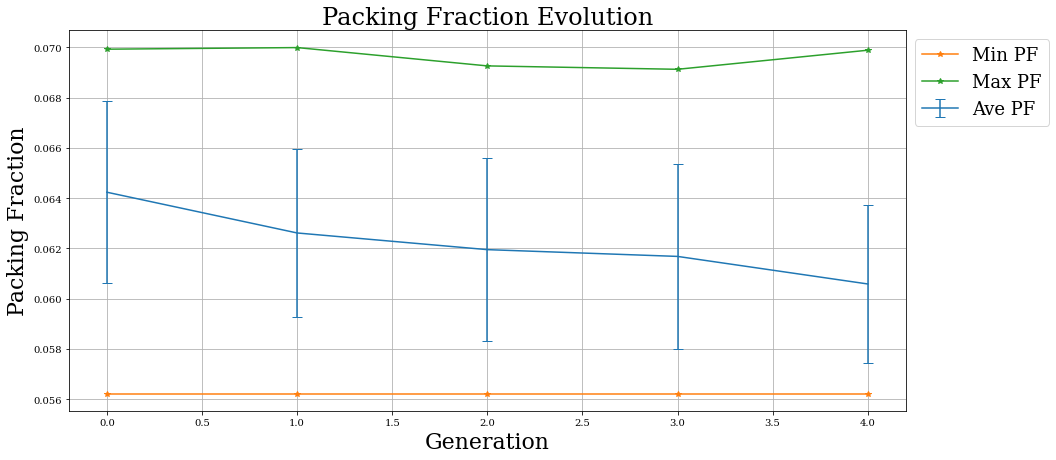

In [7]:
plot_1_obj(logbook, 0, "Packing Fraction", "PF", False, "assem-obj-2-pf-evol.png")

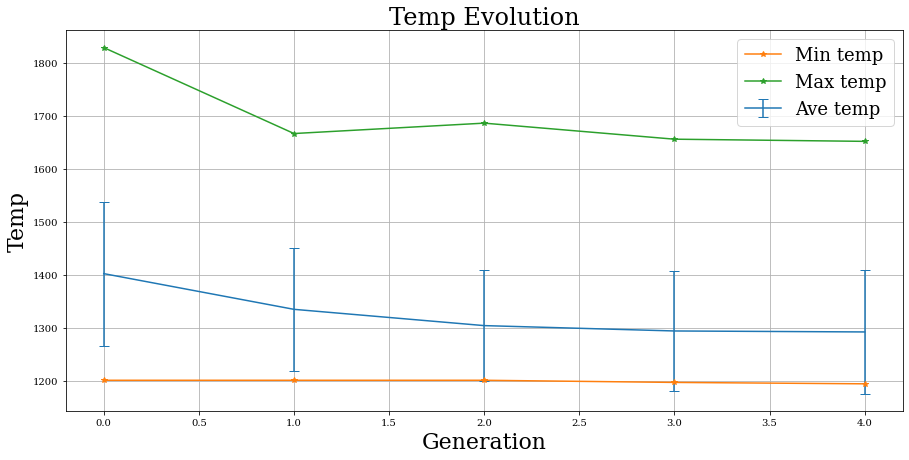

In [8]:
plot_1_obj(logbook, 1, "Temp", "temp", False, "assem-obj-2-temp-evol.png")

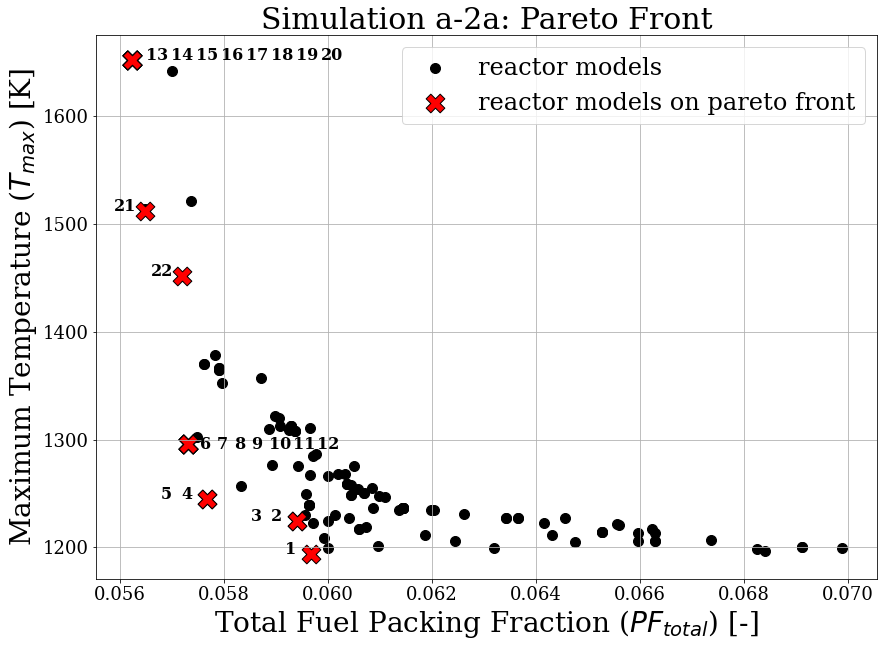

In [9]:
results = cp["all"]
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(14, 10))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black", label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black")
num = 1
prev_0, prev_1 = 0, 0
offset_x_1,offset_x_2 = 0,0
for ind in final_non_dom:
    if count2 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=350, edgecolors='black', alpha=1, color="red",
                   label="reactor models on pareto front")
        count2 += 1
    else:
        #ax.plot(ind.output[0], ind.output[1], 'rx', alpha=0.74, ms=8, mew=3)
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=350, edgecolors='black', alpha=1, color="red")
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 20
            else:
                offset_x -= 25
        else:
            offset_x = -20
        if num in range(6,10):
            offset_x_2 += 17
            offset_x = offset_x_2
        if num in range(6,13):
            offset_y = -5
        if num in range(10,13):
            offset_x_2 += 24
            offset_x = offset_x_2
        if num in range(13,21):
            offset_x_1 += 25
            offset_x = offset_x_1
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
#ax.set_xlim(0.01, 0.04)
#ax.set_ylim(1.0, 1.6)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=24, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=28)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=28)
ax.set_title('Simulation a-2a: Pareto Front',fontsize=30)
plt.savefig("assem-obj-2-pftemp-pareto",bbox_inches='tight', dpi=300)

In [10]:
len(final_non_dom)

22

In [11]:
results = cp["all"]
all_pop = []
ref = np.array([0.07,1700])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

6.0090244148723535
6.0859535682081995
6.222057147003148
6.337900049398083
6.466403668206646


In [12]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
    
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

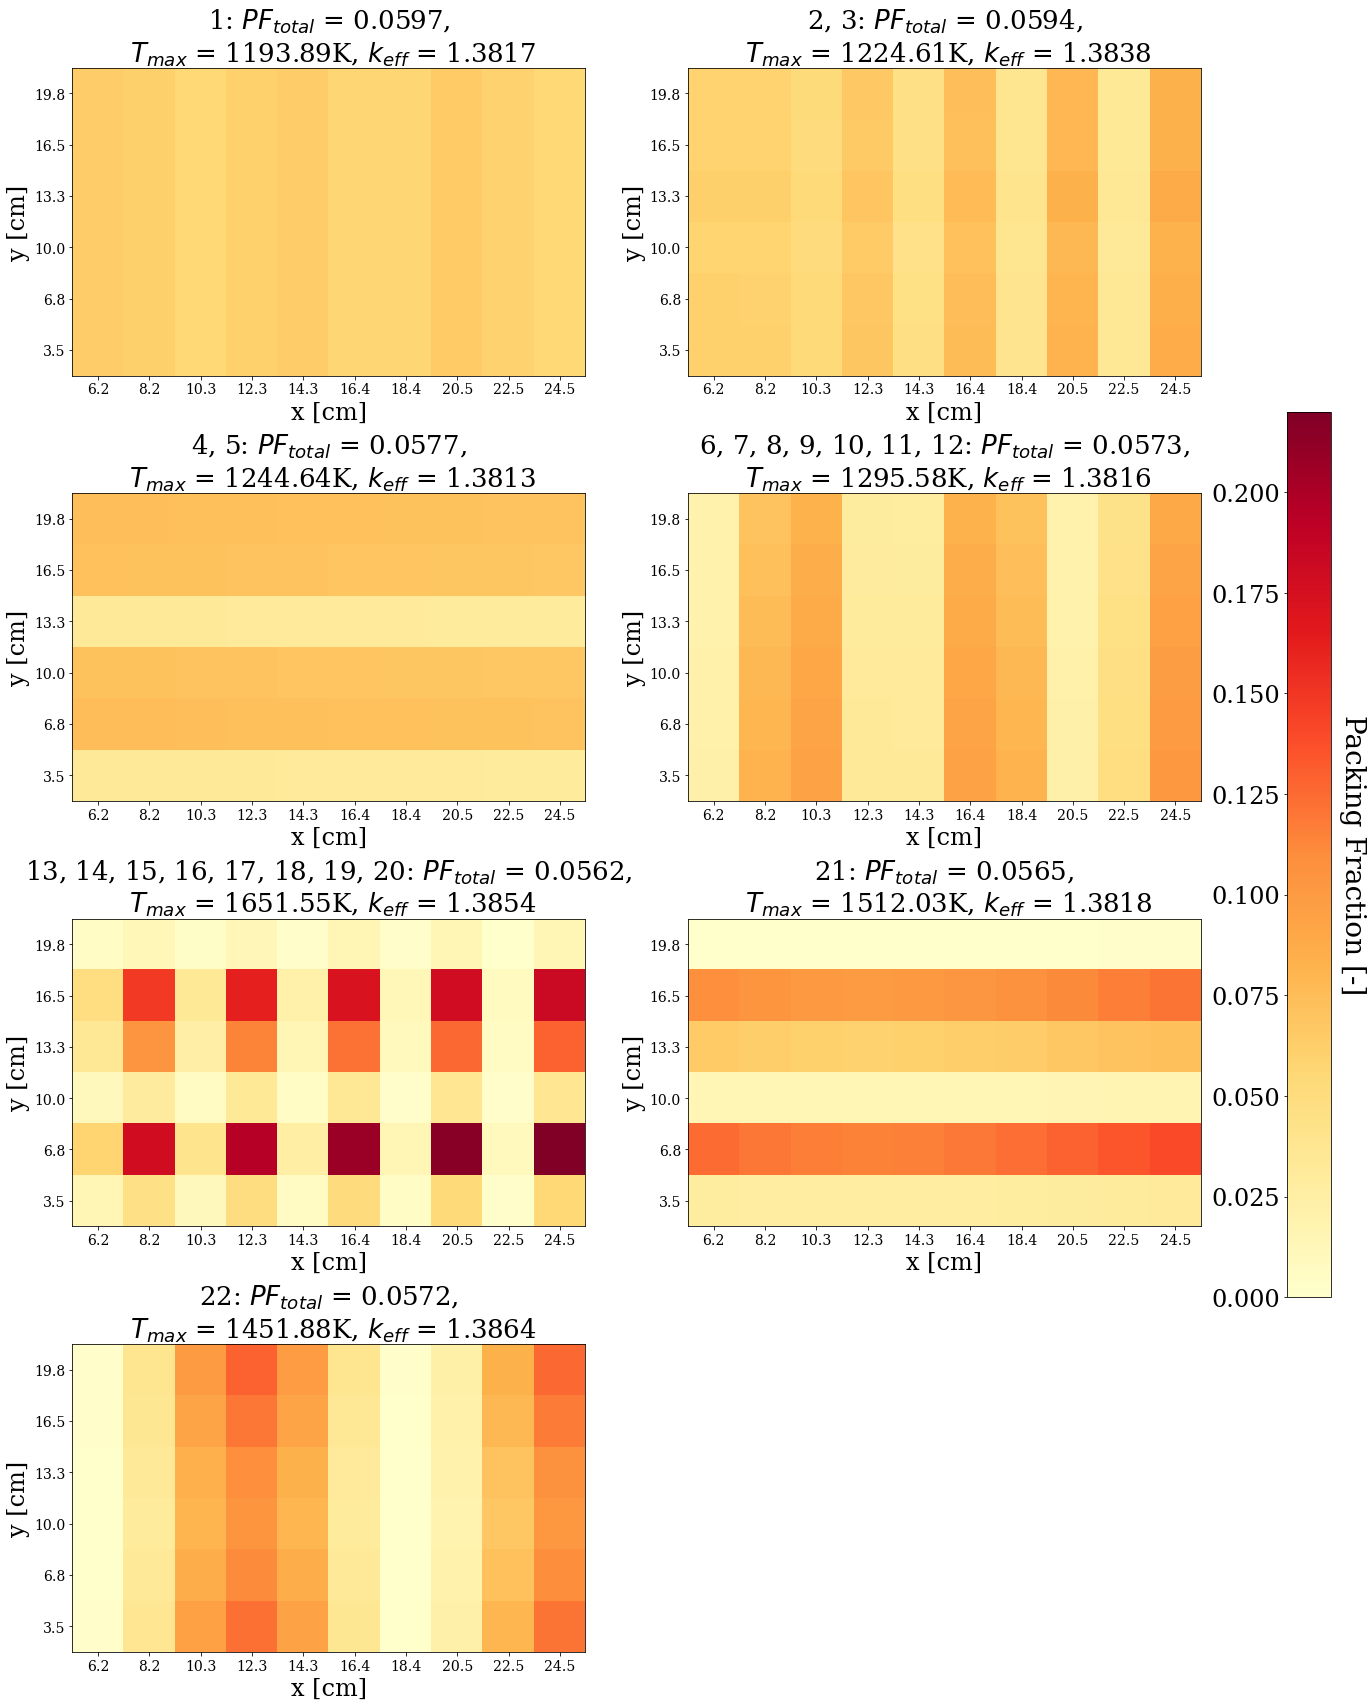

In [13]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, axes = plt.subplots(figsize=(15, 30), nrows=4, ncols=2)
count = 0
prev_pf = 0
for i, ind in enumerate(final_non_dom):
    if ind[0] != prev_pf:
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        im = ax.imshow(pf_distr, vmin=0, vmax=0.22,cmap="YlOrRd")
        if i+1 == 2:
            nums = "2, 3"
        elif i+1 == 4:
            nums = "4, 5"
        elif i+1 == 6:
            nums = "6, 7, 8, 9, 10, 11, 12"
        elif i+1 == 13:
            nums = "13, 14, 15, 16, 17, 18, 19, 20"
        else:
            nums = str(i+1)
        ax.set_title(nums + ": $PF_{total}$ = "+str(round(ind.output[0],4)) + ",\n $T_{max}$ = "+str(round(ind.output[1],2))+ 
                     "K, $k_{eff}$ = "+str(round(ind.output[2],4)), fontsize=26)
        ax.set_xlabel("x [cm]", fontsize=24)
        ax.set_ylabel("y [cm]", fontsize=24)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
        ax.tick_params(axis='both', which='major', labelsize=14)
        prev_pf = ind[0]
fig.subplots_adjust(right=1.17)
fig.delaxes(axes[3][1])
cbar_ax = fig.add_axes([1.25, 0.3, 0.04, 0.41])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=24)
cb.set_label("Packing Fraction [-]", fontsize=28, rotation=270, labelpad=35)
plt.savefig("assem-obj-2-pftemp-pareto-distr.png",bbox_inches='tight', dpi=300)

0.0006095471098955772
0.007379233086825966
0.005195764092735765
0.001493175006890336
0.008877633575322284
0.002207348130370658


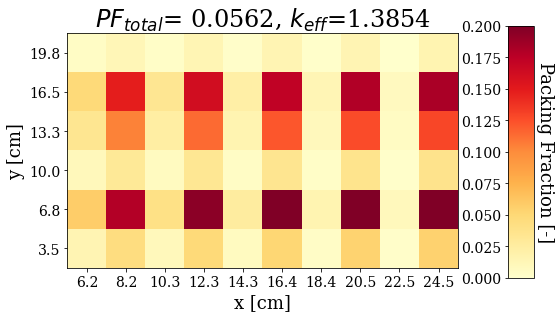

In [14]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
obj_0 = np.array([item.output[0] for item in final_non_dom])
pf_min = np.argsort(obj_0)[0]
pf_most_minimized = final_non_dom[pf_min]
pf_distr = calc_pf_distr(pf_most_minimized, True)
#print(pf_distr)
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$= "+str(round(pf_most_minimized.output[0],4))+ ", $k_{eff}$=" + str(round(pf_most_minimized.output[2],4)), fontsize=24)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
plt.savefig("a-2a-pf-most-minimized.png",bbox_inches='tight', dpi=300)


std 0.0037478145441924523
0.06454852224283117 0.0543907454753814
0.06458497378624305 0.05442146076600326
0.06462213538221337 0.05445277437067846
0.06466000418372898 0.05448468389041844
0.06469857728959656 0.05451718688058056
0.06473785174466486 0.054550280851055476


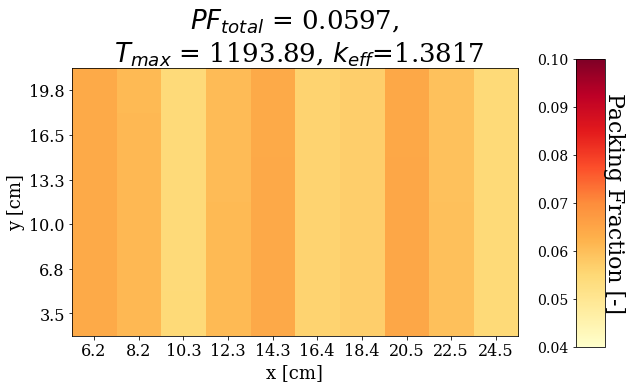

In [15]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
obj_1 = np.array([item.output[1] for item in final_non_dom])
temp_min = np.argsort(obj_1)[0]
temp_most_minimized = final_non_dom[temp_min]
pf_distr = calc_pf_distr(temp_most_minimized, True)
print("std", np.std(pf_distr))
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row), np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(temp_most_minimized.output[0],4))+ 
             ",\n $T_{max}$ = "+str(round(temp_most_minimized.output[1],2))+ 
             ", $k_{eff}$=" + str(round(temp_most_minimized.output[2],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=20)
plt.savefig("a-2a-temp-most-minimized.png",bbox_inches='tight', dpi=300)


std 0.018608089702516803
0.07385075059453178 0.06981564011227571
0.07174850787266095 0.0678282612418211
0.032223270655632505 0.030462632393348628
0.07117752243380612 0.06728847371647416
0.07438311831817515 0.07031891994493904
0.032440076165058 0.030667591927253896


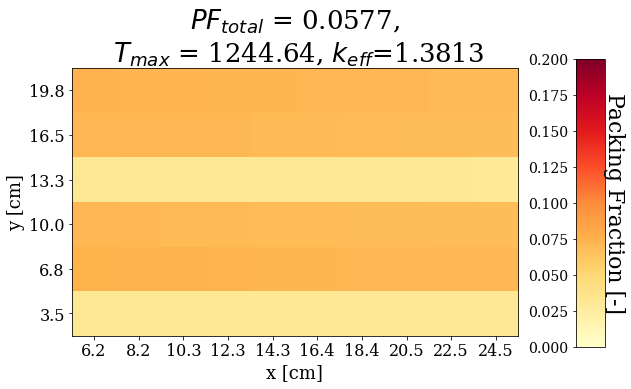

In [16]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
obj_2 = np.array([item.output[2] for item in final_non_dom])
ppf_min = np.argsort(obj_2)[0]
temp_most_minimized = final_non_dom[ppf_min]
pf_distr = calc_pf_distr(temp_most_minimized, True)
print("std", np.std(pf_distr))
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row), np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(temp_most_minimized.output[0],4))+ 
             ",\n $T_{max}$ = "+str(round(temp_most_minimized.output[1],2))+ 
             ", $k_{eff}$=" + str(round(temp_most_minimized.output[2],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=20)
plt.savefig("a-2a-balanced-reactor-model.png",bbox_inches='tight', dpi=300)


0 36
[0.056222141005180214, 1.8729264762585185, 1.4894360653269119, 2.795435625664059, 1.751069555723305, 0.722917763968658, 3.0771408521401535]
std 0.06632382009778026
max, min 0.21946584649933815 0.0006095471098955772
ROW
1 0.014
1 0.015 0.001
2 0.175
2 0.182 0.007
3 0.123
3 0.128 0.005
4 0.035
4 0.037 0.001
5 0.211
5 0.219 0.009
6 0.052
6 0.055 0.002
COLUMN
1 0.054
2 0.166
3 0.037
4 0.181
5 0.024
6 0.193
7 0.014
8 0.201
9 0.008
10 0.204


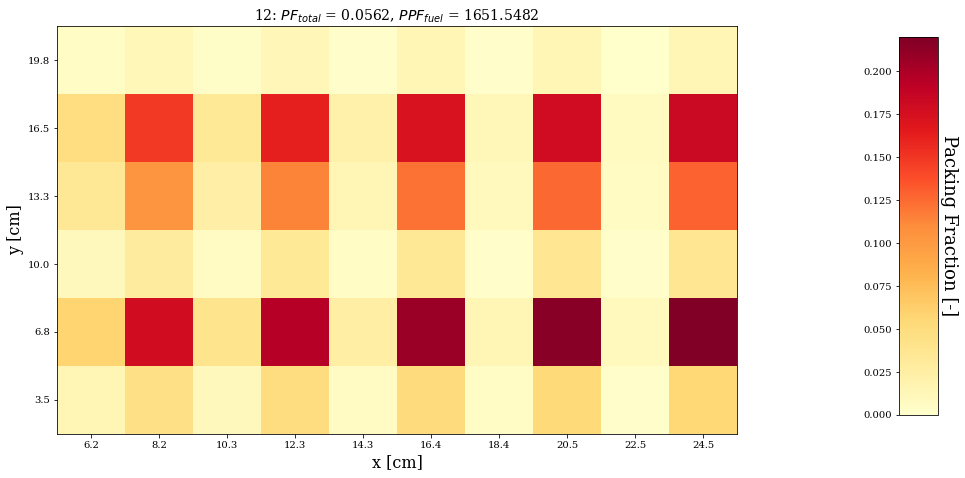

In [17]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, ax = plt.subplots(figsize=(18,7.5))
num = 12
ind = final_non_dom[num]
print(ind.gen, ind.num)
print(ind)
pf_distr = calc_pf_distr(ind, True)
print("std", np.std(pf_distr))
print("max, min", np.amax(pf_distr), np.amin(pf_distr))
print("ROW")
for i, row in enumerate(pf_distr):
    print(i+1, round(np.max(row)- np.min(row),3))
    print(i+1, round(np.max(row),3), round(np.min(row),3))
print("COLUMN")
for i in range(10):
    col = pf_distr[:, i]
    print(i+1, round(np.max(col)-np.min(col),3))
    #print(i+1, round(np.max(col),3), round(np.min(col),3))
im = ax.imshow(pf_distr, vmin=0.0, vmax=0.22,cmap="YlOrRd")
ax.set_title(str(num)+": $PF_{total}$ = "+str(round(ind.output[0],4)) + ", $PPF_{fuel}$ = "+str(round(ind.output[1],4)), fontsize=14)
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("y [cm]", fontsize=16)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
#plt.savefig("assem-obj-2-pfppf-pareto-distr.png",bbox_inches='tight')